# Juan Carlos Cox Fernández

# Importación de librerias

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from google.colab import drive, files

# Carga de datos

In [4]:
# Montar Google Drive para acceder a los datos
drive.mount('/content/drive')
path = '/content/drive/MyDrive/datasets/'

# Cargar los datos
train_features = pd.read_csv(path + 'dengue_features_train.csv')
train_labels = pd.read_csv(path + 'dengue_labels_train.csv')
test_features = pd.read_csv(path + 'dengue_features_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocesamiento de datos

In [5]:
# Rellenar valores faltantes con la mediana
numeric_cols = train_features.select_dtypes(include=[np.number]).columns
train_features[numeric_cols] = train_features[numeric_cols].fillna(train_features[numeric_cols].median())
test_features[numeric_cols] = test_features[numeric_cols].fillna(test_features[numeric_cols].median())

# Exploración de datos

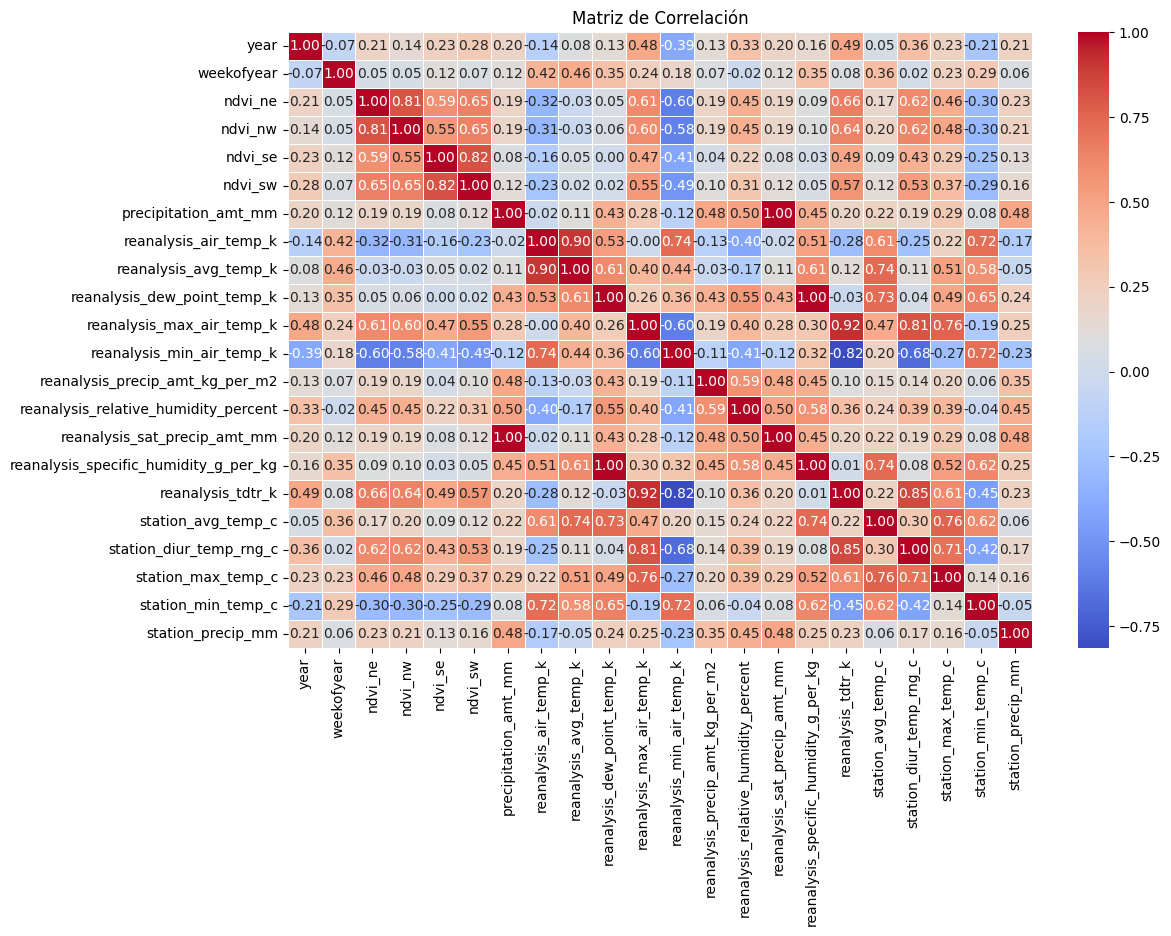

In [6]:
# Matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(train_features[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# Selección de características

In [16]:
# Selección de características
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(train_features[numeric_cols], train_labels['total_cases'])
selected_columns = train_features[numeric_cols].columns[selector.get_support()]

print("Características seleccionadas:", selected_columns.tolist())

Características seleccionadas: ['year', 'weekofyear', 'ndvi_ne', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_tdtr_k', 'station_diur_temp_rng_c', 'station_min_temp_c']


# Preparación de datos

In [8]:
# Definir variables predictoras y objetivo
X = pd.DataFrame(X_selected, columns=selected_columns)
y = train_labels['total_cases']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_features[selected_columns])

# División del dataset (70-30)

In [9]:
# Separar en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Modelos y optimización

In [10]:
# Modelos y optimización
models = {
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Ridge Regression": Ridge()
}

# Hiperparámetros a optimizar
param_grid = {
    "KNN": {'n_neighbors': [3, 5, 7]},
    "Random Forest": {'n_estimators': [50, 100, 150]},
    "Ridge Regression": {'alpha': [0.1, 1.0, 10]}
}

# Entrenamiento y evaluación

In [11]:
# Evaluación de modelos
mae_scores = {}
best_models = {}
for name, model in models.items():
    if name in param_grid:
        grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        mae_scores[name] = -grid_search.best_score_
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
        mae_scores[name] = -scores.mean()
        best_models[name] = model.fit(X_train, y_train)

    print(f'{name} MAE: {mae_scores[name]:.2f}')

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Naive Bayes MAE: 23.06
KNN MAE: 16.11
Random Forest MAE: 12.16
Ridge Regression MAE: 19.05


# Selección del mejor modelo

El mejor modelo es: Random Forest


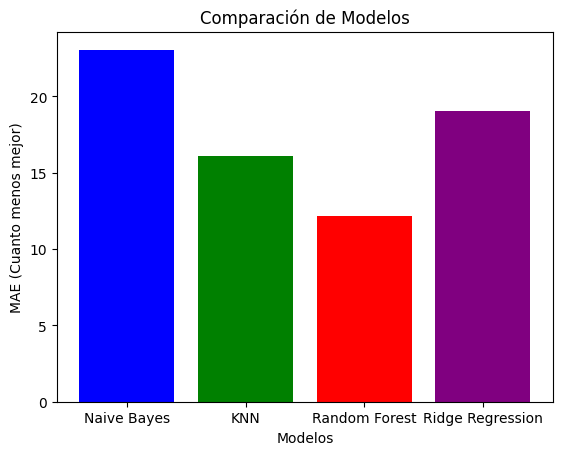

In [12]:
# Seleccionar el mejor modelo
best_model_name = min(mae_scores, key=mae_scores.get)
best_model = best_models[best_model_name]
print(f'El mejor modelo es: {best_model_name}')

# Comparación gráfica de modelos
plt.bar(mae_scores.keys(), mae_scores.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Modelos')
plt.ylabel('MAE (Cuanto menos mejor)')
plt.title('Comparación de Modelos')
plt.show()

# Evaluación de validación

In [13]:
# Predicción en validación
y_pred = best_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'MAE en conjunto de validación ({best_model_name}): {mae:.2f}')

MAE en conjunto de validación (Random Forest): 12.49


# Predicción

In [14]:
# Predicción en test
test_predictions = best_model.predict(test_scaled)
test_features['total_cases'] = np.round(test_predictions).astype(int)

# Descarga de los resultados

In [15]:
# Guardar y descargar resultados
submission = test_features[['city', 'year', 'weekofyear', 'total_cases']]
submission.to_csv('submission.csv', index=False)
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>